In [1]:
import sys; sys.path.append("..")
import os

import dagpipe


os.environ["PATH"] += os.pathsep + './Graphviz/bin/'

TODO
- [ ] pipeline.to_task docstring similar to pipeline.run
  - [ ] rename task_name to input_task_name
- [ ] StoppingTaskHolder propagation!
  - [ ] with root and traceback properties  
- [ ] debug method in task
- [ ] check if first node is in inputs
- [ ] remove args from task decorators
- [ ] split task_core to folder
  - [ ] extract TaskIterator
- [ ] hide attributes in properties
- [ ] extract all input/output/type parsers from pipeline to separate class
- [ ] move conditionals stops to to tasks
- [ ] create inputs and outputs objects
- [ ] throw errors when during graph creation currently checked task don't have parents but is not in inputs
- [ ] visualization _build_graph refactor
- [ ] implement insert, remove, replace methods for pipeline
- [ ] pipeline to md
- [ ] hide nodes by regex on visualization
- [ ] prevent from creating pipeline with two tasks with the same name
- [ ] add get_from to StoppingTaskHolder
- [ ] add inputs to task that will return args and kwargs
- [x] list tasks with those from nested subpielines
- [x] visualize somehow when output is in the middle of pipeline
- [x] visualize somehow when output is a task reference 
- [x] create set_outputs
- [x] create split_output
- [x] add to_task method with task decorator to pipeline
- [x] don't use strict mode in visualization, manually remove redundant edges
- [x] create \_\_version\_\_
- [x] implement with_outputs method for pipeline
- [x] getting pipeline from task


Issues
- [x] when *args with shorten length provided. Remaining params from last run added to args (may help if uniform_args_kwargs_order will return *args and **kwargs separately) # issue1
- [ ] visualization of reference as output # issue2
- [x] pipeline run return type hint
- [x] args/kwargs incompatibility
- [x] pip install -U dagpiple dont update to newer version


['left', 'right']

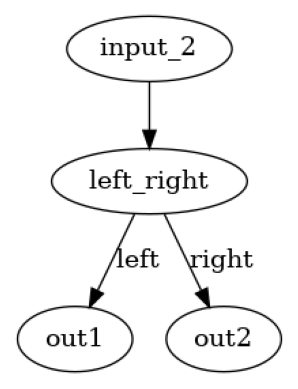

In [2]:
from typing import Any

@dagpipe.task()
def input_(inp):
    return inp


@dagpipe.task()
def input_2(inp):
    return inp

@dagpipe.task()
def left_right(inp):
    return "left", "right"

@dagpipe.task()
def zip_task(l, r):
    return (l, r)

inp = input_2(Any)
l, r = left_right(inp).split_output(["left", "right"])

l2 = input_(l).set_name("out1")
out = input_(r).set_name("out2")

p = dagpipe.Pipeline(inp, [l2, out])
dagpipe.visualize(p)
p.run(Any)


In [3]:
def foo():
    return None

def f1():
    return 1

foo.f1 = f1


foo.f1



<function __main__.f1()>

In [4]:
# from typing import Any

# from dagpipe.task_core import Task
# from dagpipe.task_decorators import method_task, task


# class Input:
#     """
#     A class providing methods to create different types of input tasks for a pipeline.

#     Methods:
#         single(): Creates a task that takes end returns a single input argument.
#         args2tuple(): Creates a task that converts input arguments to a tuple.
#         kwargs2dict(): Creates a task that converts keyword arguments to a dictionary.
#     """

#     @classmethod
#     def base(cls) -> Task:
#         """
#         Create a task that takes a single input argument.

#         This method is syntactic sugar that indicates a single input on the pipeline entry.

#         Returns:
#             Task: A Task instance that takes a single input argument.
#         """
#         @task()
#         def _single(arg: Any):
#             return arg
#         return _single(None).set_name("input")
        
#     @classmethod
#     def args2tuple(cls) -> Task:
#         """
#         Create a task that converts input arguments to a tuple.

#         Returns:
#             Task: A Task instance that converts input arguments to a tuple.
#         """
#         @task()
#         def _args2tuple(*args):
#             return args
#         return _args2tuple().set_name("input")
    
#     @classmethod
#     def kwargs2dict(cls) -> Task:
#         """
#         Create a task that converts keyword arguments to a dictionary.

#         Returns:
#             Task: A Task instance that converts keyword arguments to a dictionary.
#         """
#         @task()
#         def _kwargs2dict(**kwargs):
#             return kwargs
#         return _kwargs2dict().set_name("input")


# class Output:
#     @classmethod
#     def base(cls, arg):
#         """
#         This method is syntactic sugar for output.

#         Returns:
#             Task: A Task instance that takes a single input argument.
#         """
#         @task()
#         def _single(arg: Any):
#             return arg
#         return _single(arg).set_name("output")
    



In [5]:
from typing import Iterable


isinstance("as", Iterable)

True

In [6]:

@dagpipe.task()
def do_nothing(a, *args):
    return a, args

inp = do_nothing(Any)
x = do_nothing(inp)
x2 = do_nothing(x)

    
p = dagpipe.Pipeline(inp, x2)

o = p.run(1, 2, 3) # <- second run return 10, 12 instead of 10
print(o, "<-- final output")

[(((1, (2, 3)), ()), ())] <-- final output


In [7]:
# issue1

@dagpipe.task()
def do_nothing(inp):
    print(inp)
    return inp



inp = do_nothing(Any)
x = do_nothing(inp)
x2 = do_nothing(x)

    
p = dagpipe.Pipeline(inp, x2)

p.run(10) # <- second run return 10, 12 instead of 10


10
10
10


[10]

(10, 12)
((10, 12),)
(((10, 12),),)
(10,)
((10,),)
(((10,),),)


([(((10, 12),),)], [(((10,),),)])

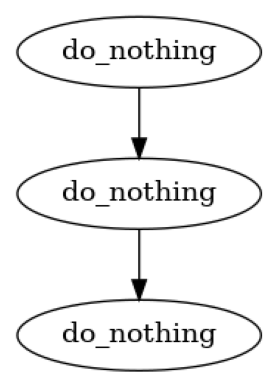

In [8]:
# issue1

@dagpipe.task()
def do_nothing(*inp):
    print(inp)
    return inp



inp = do_nothing(Any)
x = do_nothing(inp)
x2 = do_nothing(x)

    
p = dagpipe.Pipeline(inp, x2)

dagpipe.visualize(p)
p.run(10, 12), p.run(10) # <- second run return 10, 12 instead of 10


In [9]:
# issue1

@dagpipe.task()
def do_nothing(inp):
    return inp



inp = do_nothing(Any)
x = do_nothing(inp)
# x2 = Output.base(x)
x2 = do_nothing(x)

    
p = dagpipe.Pipeline(inp, x2)

p.run(10) # <- second run return 10, 12 instead of 10


[10]

[1, (1, 2)]

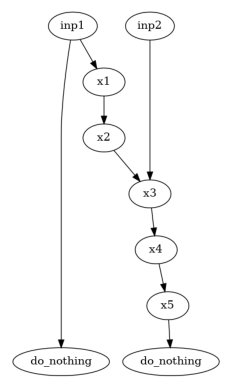

In [10]:
@dagpipe.task()
def do_nothing(inp):
    return inp

@dagpipe.task()
def zip_(*args):
    return args


inp1 = do_nothing(Any).set_name("inp1")
inp2 = do_nothing(Any).set_name("inp2")

x1 = do_nothing(inp1).set_name('x1')
x2 = do_nothing(x1).set_name('x2')
x3 = zip_(x2, inp2).set_name('x3')
x4 = do_nothing(x3).set_name('x4')
x5 = do_nothing(x4).set_name('x5')


out1 = do_nothing(inp1)
out2 = do_nothing(x5)
p = dagpipe.Pipeline([inp1, inp2], [out1, out2])
# p = dagpipe.Pipeline(inputs=[inp1, inp2], outputs=out2)
dagpipe.visualize(p)

p.run(inp1=1,inp2=2)

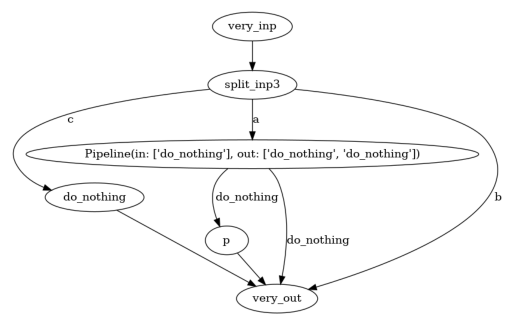

[[1, 2, 3], [4, 5, 6]]

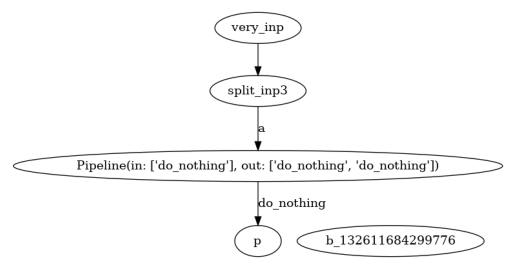

In [11]:
# issue2

@dagpipe.task()
def do_nothing(inp):
    return inp

@dagpipe.task(outputs_num=2)
def split_inp2(inp):
    return inp

@dagpipe.task(outputs_num=3)
def split_inp3(inp):
    return inp


@dagpipe.task()
def zip_(*args):
    return args


@dagpipe.task()
def never_default(inp, arg=34):
    if arg==34:
        raise RuntimeError("arg should not be equal 34")
    if inp==34:
        raise RuntimeError("inp should not be equal 34 even more!")
    
    return inp


inp = do_nothing(Any)
x = do_nothing(inp)
x = do_nothing(x)
x = never_default(x, arg=11)
x = do_nothing(x)

    
p = dagpipe.Pipeline(inp, [x, x])

inp = do_nothing(Any).set_name("very_inp") #[1,2,3], [4,5,6], [7,8,9]]
a, b, c = split_inp3(inp).split_output(["a", "b", "c"]) #[1,2,3], [4,5,6], [7,8,9]]
p1, p2 = p.to_task(a)
# p1, p2 = split_inp2(a) #1, 2
p22 = do_nothing(p2).set_name("p") # 2
c2 = do_nothing(c) # [7,8,9]
out = zip_(b, c2, p1, p22).set_name("very_out")

nested_p = dagpipe.Pipeline(inp, out)
nested_p2 = nested_p.with_outputs(["p", "b"])
dagpipe.visualize(nested_p)
import matplotlib.pyplot as plt

plt.show()
dagpipe.visualize(nested_p2)
nested_p2.run([[1,2,3], [4,5,6], [7,8,9]])

In [12]:
nested_p2.nested_tasks

[Task<very_inp>, TaskRef0<a>, TaskRef1<do_nothing>, Task<p>, TaskRef1<b>]

[([1, 2, 3], 'c===============================3', [7, 8, 9])]

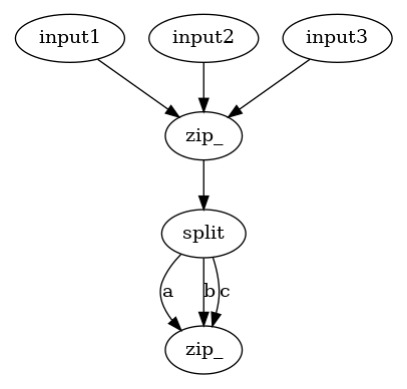

In [13]:
@dagpipe.task()
def do_nothing(param):
    return param

@dagpipe.task(outputs_num=3)
def split(param):
    return param

@dagpipe.task()
def zip_(*param):
    return param

inp1 = do_nothing(Any).set_name("input1")
inp2 = do_nothing(Any).set_name("input2")
inp3 = do_nothing(Any).set_name("input3")
inp = zip_(inp1, inp2, inp3)
a, b, c = split(inp).set_name(["a", "b", "c"])
# a = do_nothing(a)
# b = do_nothing(b)
out = zip_(a, b, c)

p = dagpipe.Pipeline([inp1, inp2, inp3], out)

dagpipe.visualize(p)
p.run(input1=[1,2,3], input2="c===============================3", input3=[7,8,9])



['Output of F with Output of E with Output of D with Output of A with asd and Output of C with Output of B with B input', 'Output from Exampleclass with Output of G with Output of C with Output of B with B input']


[Task<A>,
 Task<B>,
 Task<C>,
 Task<D>,
 Task<E>,
 Task<FFFFFF>,
 Task<G>,
 Task<__call__>]

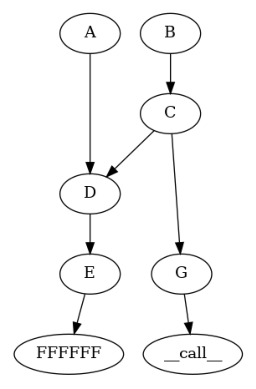

In [14]:

# Example task functions
@dagpipe.task()
def A(param):
    return f"Output of A with {param}"

@dagpipe.task()
def B(a):
    return f"Output of B with {a}"

@dagpipe.task()
def C(b):
    return f"Output of C with {b}"

@dagpipe.task()
def D(a, c):
    return f"Output of D with {a} and {c}"

# Example class with method tasks
class ExampleClass:
    @dagpipe.task()
    def E(self, d):
        return f"Output of E with {d}"

    @dagpipe.task("FFFFFF")
    def F(self, e):
        return f"Output of F with {e}"

    @dagpipe.task()
    def G(self, inp):
        return f"Output of G with {inp}"

    @dagpipe.task()
    def __call__(self, inp):
        return f"Output from Exampleclass with {inp}"

# Define the data flow
a = A(param="Initial input for A")
b = B("Any")
c = C(b)
d = D(a, c)

example = ExampleClass()
e = example.E(d)
f = example.F(e)
g = example.G(c)
ec = example(g)

# Create and run the pipeline
pipeline = dagpipe.Pipeline(inputs=[a, b], outputs=[f, ec])
result = pipeline.run(A="asd", B="B input")
print(result)

# Run the pipeline with a different argument for A
# new_result = pipeline.run(param="###### New input for A")
# print(new_result)

# new_result2 = pipeline.run(param="@@@@@ New input for A")
# print(new_result2)

# Visualize the pipeline without saving
# pipeline.visualize()
dagpipe.visualize(pipeline)

# Visualize the pipeline and save as PNG
pipeline.tasks

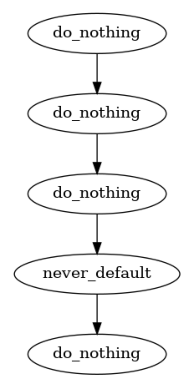

[]

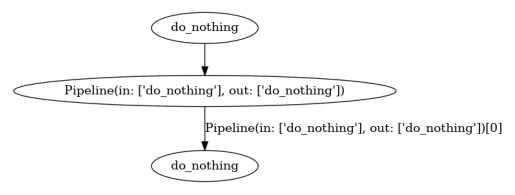

In [15]:
inp = do_nothing(Any)
x = do_nothing(inp)
x = do_nothing(x)
x = never_default(x, arg=11)
x = do_nothing(x)

    
p = dagpipe.Pipeline(inp, x)
p.tasks
dagpipe.visualize(p)
plt.show()


inp = do_nothing(Any)
(x, ) = p.to_task(inp)
x = do_nothing(x)

p_wrapper = dagpipe.Pipeline(inp, x)
dagpipe.visualize(p_wrapper)
p_wrapper.find("never_default")

In [16]:
p_wrapper.run(123)

[123]